# IMPORT LIBRARIES

In [478]:
import pandas as pd

import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, r2_score

import seaborn as sns

import matplotlib.pyplot as plt

import os

import tensorflow as tf

# CONFIGURATION

In [479]:
sOutputSymbol = 'BTCUSD'
sModelType = 'MLP'
sSource = 'Steepest Descent'

iTrialId = 36

In [480]:
dfDesign = pd.read_csv('Data/'+ sSource +'_'+ sOutputSymbol +'_'+ sModelType +'.csv', index_col = 0)
iBatchSize = dfDesign.loc[iTrialId, 'Batch Size']
iNrOfHiddenNeurons = dfDesign.loc[iTrialId, 'Number of Hidden Neurons']
iBackwardTimeWindow = 3
iForwardTimeWindow = 3

In [481]:
sModelName = os.path.join(sOutputSymbol , sModelType + '_' + str(iTrialId))

In [482]:
dfOhlc = pd.read_csv('Data\dfOhlc.csv', index_col = 0)
dfActual = pd.read_csv(sModelName+'\dfActual.csv',header=[0, 1], index_col=0)
dfPrediction = pd.read_csv(sModelName+'\dfPrediction.csv',header=[0, 1], index_col=0)
dfPerformance = pd.read_csv(sModelName+'\dfPerformance.csv', index_col=0)

# CONVERT [return] TO [close]

In [483]:
def dfGetClosePricesFromReturns(dfToConvert):
    dfClose = dfToConvert.copy() 
    
    for sCol in dfClose.columns:
        iTimeStep = int(sCol[0])
        sSymbolFeature = sCol[1]
        aSymbolFeature = sSymbolFeature.split(':')
        sSymbol = aSymbolFeature[0]
        sFeature = aSymbolFeature[1]
        
        dfReturns = dfToConvert.loc[:,sCol ]

        if iTimeStep == 0:
            dfOpenPrices = dfOhlc.loc[dfClose.index, sSymbol+':open']
        else:
            dfOpenPrices =  dfClose.loc[:, (str(iTimeStep-1), sSymbolFeature)]
        
        dfClose.loc[:, sCol] = (dfOpenPrices * dfReturns) + dfOpenPrices
    
    dfClose.rename(columns = {sOutputSymbol+':return' :sOutputSymbol+':close'}, level=1, inplace = True)
    return dfClose

In [484]:
dfActualClose = dfGetClosePricesFromReturns(dfActual)
dfPredictionClose = dfGetClosePricesFromReturns(dfPrediction)

# CONVERT [return] OF COMBINATIONS

In [485]:
def dfGetCombinationsOfReturns(dfToConvert):
    dfConverted = pd.DataFrame(index = dfToConvert.index)
    for i in range(0, dfToConvert.shape[1]):
        for j in range(i, dfToConvert.shape[1]): 
            dfConverted.loc[: , str(i) + '_' + str(j) ] = dfToConvert.iloc[:, i:j+1].sum(axis = 1)
            
    return dfConverted
    

In [486]:
dfActualReturnCombinations = dfGetCombinationsOfReturns(dfActual)
dfPredictionReturnCombinations = dfGetCombinationsOfReturns(dfPrediction)

# SAVE RESULTS 

## Define Custom Metric Function

In [487]:
def fCalculateCustomMetric(aActual,aPrediction):
    aLossDueToError = tf.math.subtract(aActual,aPrediction)
    aLossDueToError = tf.where(aLossDueToError < 0 , aLossDueToError, 0 )
    aLossDueToError = tf.math.abs(aLossDueToError)

    fPenalty = tf.math.reduce_max(aLossDueToError)

    aLossDueToSignDiff = tf.math.abs(tf.math.subtract(tf.math.sign(aActual), tf.math.sign(aPrediction)) )
    aLossDueToSignDiff = tf.where(aLossDueToSignDiff == 0, aLossDueToSignDiff, fPenalty)

    aTotalLoss = aLossDueToError + aLossDueToSignDiff
    fAggLoss = tf.math.reduce_sum(aTotalLoss).numpy()
    return fAggLoss

## Log Metrics

In [488]:
y_pred = dfPredictionClose.iloc[:, :]
y_true = dfActualClose.iloc[:, :]

dictMetrics = {
    'mean absolute error': mean_absolute_error(y_true, y_pred),
    'mean squared error': mean_squared_error(y_true, y_pred),
    'r2 score': r2_score(y_true, y_pred),
    'custom_metric' : fCalculateCustomMetric(y_true, y_pred)
}

dfMetrics = pd.DataFrame.from_dict(data = dictMetrics, orient = 'index', columns = ['value'])
dfPerformance.drop(dfMetrics.index, axis = 0, inplace = True, errors = 'ignore')
dfPerformance.append(dfMetrics).to_csv(sModelName+'\dfPerformance.csv')

# PLOT RESULTS

## Single Time Step Comparision

In [489]:
iComparisionTimeStep = 0

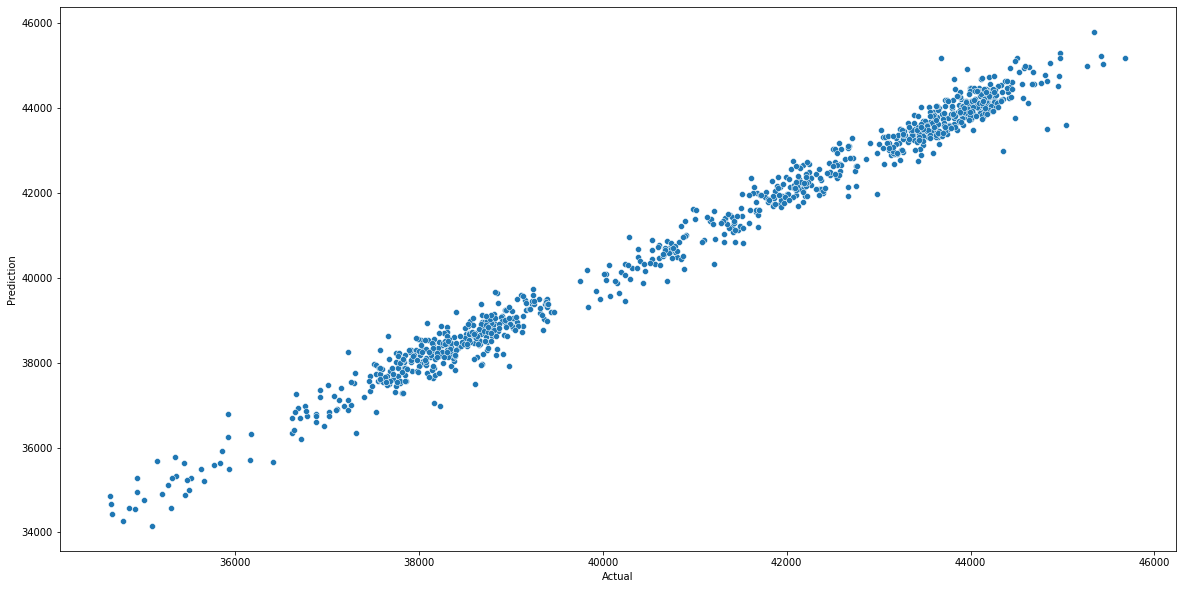

In [490]:
dfTestComparision = pd.DataFrame(dfPredictionClose.iloc[:,iComparisionTimeStep])
dfTestComparision = dfTestComparision.join(dfActualClose.iloc[:,iComparisionTimeStep], how = "inner", lsuffix="prediction")
dfTestComparision.columns = ["Prediction", "Actual"]

plt.figure(figsize = (20,10))
oFig = sns.scatterplot(data = dfTestComparision, x = "Actual", y ="Prediction")
oFig.get_figure().savefig(sModelName + '\closing price scatter.png')

## Multi Step Comparision